In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install wandb
!pip install -q wandb

# Imports
import os
import json
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import wandb


In [3]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/content/drive/MyDrive/Colab Notebooks/Ayna ML Internship Assignment/dataset"

# Dynamically extract all color names from JSON
import json

def extract_colors(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return set([item['colour'].lower() for item in data])

train_colors = extract_colors(f"{root_dir}/training/data.json")
val_colors = extract_colors(f"{root_dir}/validation/data.json")

all_colors = sorted(list(train_colors.union(val_colors)))
color2idx = {color: idx for idx, color in enumerate(all_colors)}
num_colors = len(color2idx)
print("Color classes:", color2idx)


Color classes: {'blue': 0, 'cyan': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'purple': 5, 'red': 6, 'yellow': 7}


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, color_embed_dim=64):
        super().__init__()
        self.color_embedding = nn.Embedding(num_colors, color_embed_dim)

        self.inc = DoubleConv(in_channels + 1, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, color_idx):
        B, _, H, W = x.size()
        color_embed = self.color_embedding(color_idx).view(B, 1, 1, -1)
        color_map = color_embed.expand(B, H, W, -1).permute(0, 3, 1, 2)  # [B, 1, H, W]

        x = torch.cat([x, color_map[:, 0:1, :, :]], dim=1)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3)
        x = self.conv1(torch.cat([x, x2], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x1], dim=1))
        return self.outc(x)


In [5]:
class PolygonDataset(Dataset):
    def __init__(self, input_dir, output_dir, json_path, transform=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)

        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_path = os.path.join(self.input_dir, item['input_polygon'])
        output_path = os.path.join(self.output_dir, item['output_image'])

        input_img = Image.open(input_path).convert('L')
        output_img = Image.open(output_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        color = item['colour'].lower()
        if color not in color2idx:
            color2idx[color] = len(color2idx)
        color_idx = torch.tensor(color2idx[color])

        return input_img, color_idx, output_img


In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = PolygonDataset(
    input_dir=f"{root_dir}/training/inputs",
    output_dir=f"{root_dir}/training/outputs",
    json_path=f"{root_dir}/training/data.json",
    transform=transform
)

val_dataset = PolygonDataset(
    input_dir=f"{root_dir}/validation/inputs",
    output_dir=f"{root_dir}/validation/outputs",
    json_path=f"{root_dir}/validation/data.json",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [7]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

wandb.init(project="ayna-ml-intern", name="unet-polygon-color")

for epoch in range(20):
    model.train()
    total_loss = 0
    for x, c, y in tqdm(train_loader):
        x, c, y = x.to(device), c.to(device), y.to(device)
        preds = model(x, c)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    wandb.log({"Train Loss": avg_loss})

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, c, y in val_loader:
            x, c, y = x.to(device), c.to(device), y.to(device)
            preds = model(x, c)
            val_loss += criterion(preds, y).item()
    val_loss /= len(val_loader)
    wandb.log({"Val Loss": val_loss})

    print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rukesh1704 (rukesh1704-mit-anna-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 4/4 [01:18<00:00, 19.72s/it]


Epoch 1 - Train Loss: 0.5943, Val Loss: 5.9980


100%|██████████| 4/4 [00:55<00:00, 13.81s/it]


Epoch 2 - Train Loss: 1.0839, Val Loss: 0.4310


100%|██████████| 4/4 [00:56<00:00, 14.07s/it]


Epoch 3 - Train Loss: 0.4868, Val Loss: 0.5315


100%|██████████| 4/4 [00:55<00:00, 13.95s/it]


Epoch 4 - Train Loss: 0.4323, Val Loss: 0.3463


100%|██████████| 4/4 [00:53<00:00, 13.49s/it]


Epoch 5 - Train Loss: 0.2124, Val Loss: 0.0912


100%|██████████| 4/4 [00:53<00:00, 13.44s/it]


Epoch 6 - Train Loss: 0.1956, Val Loss: 0.0934


100%|██████████| 4/4 [01:00<00:00, 15.10s/it]


Epoch 7 - Train Loss: 0.1165, Val Loss: 0.0826


100%|██████████| 4/4 [00:55<00:00, 13.99s/it]


Epoch 8 - Train Loss: 0.1259, Val Loss: 0.0860


100%|██████████| 4/4 [00:55<00:00, 13.82s/it]


Epoch 9 - Train Loss: 0.1140, Val Loss: 0.0730


100%|██████████| 4/4 [00:55<00:00, 13.90s/it]


Epoch 10 - Train Loss: 0.0983, Val Loss: 0.0830


100%|██████████| 4/4 [00:54<00:00, 13.60s/it]


Epoch 11 - Train Loss: 0.1024, Val Loss: 0.0711


100%|██████████| 4/4 [00:54<00:00, 13.66s/it]


Epoch 12 - Train Loss: 0.0921, Val Loss: 0.0709


100%|██████████| 4/4 [00:56<00:00, 14.25s/it]


Epoch 13 - Train Loss: 0.0913, Val Loss: 0.0658


100%|██████████| 4/4 [00:55<00:00, 13.88s/it]


Epoch 14 - Train Loss: 0.0911, Val Loss: 0.0633


100%|██████████| 4/4 [00:55<00:00, 13.78s/it]


Epoch 15 - Train Loss: 0.0867, Val Loss: 0.0662


100%|██████████| 4/4 [00:53<00:00, 13.39s/it]


Epoch 16 - Train Loss: 0.0860, Val Loss: 0.0652


100%|██████████| 4/4 [00:54<00:00, 13.62s/it]


Epoch 17 - Train Loss: 0.0869, Val Loss: 0.0631


100%|██████████| 4/4 [01:01<00:00, 15.40s/it]


Epoch 18 - Train Loss: 0.0838, Val Loss: 0.0643


100%|██████████| 4/4 [00:55<00:00, 13.94s/it]


Epoch 19 - Train Loss: 0.0829, Val Loss: 0.0598


100%|██████████| 4/4 [00:55<00:00, 13.92s/it]


Epoch 20 - Train Loss: 0.0856, Val Loss: 0.0648


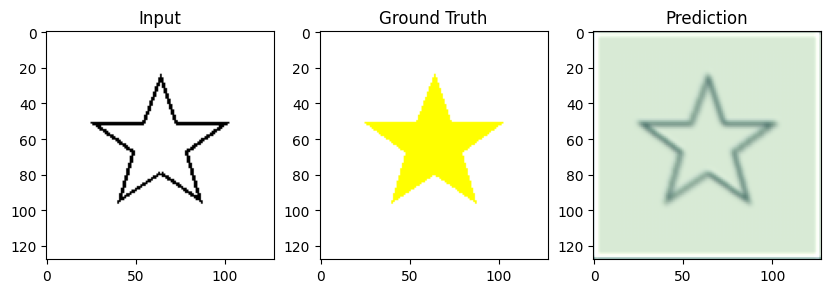

In [8]:
def visualize_prediction(model, dataset, index):
    model.eval()
    x, c, y = dataset[index]
    x, c = x.unsqueeze(0).to(device), c.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x, c).squeeze(0).cpu()
    pred = pred.permute(1, 2, 0).numpy()
    x = x.squeeze().cpu().numpy()
    y = y.permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(x, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred)
    plt.show()

# Example
visualize_prediction(model, val_dataset, index=0)


In [9]:
# Save
torch.save(model.state_dict(), "unet_colored_polygon.pth")
